<a href="https://colab.research.google.com/github/99tanya99/News/blob/main/%D0%9C%D0%9E%D0%B13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание датасета

### Описание переменных в датасете

#### Основные переменные:
1. **`date`**  
   - **Тип**: `datetime`  
   - **Описание**: Дата и время публикации поста в формате `YYYY-MM-DD HH:MM:SS`.  
   - **Пример**: `2023-01-10 16:19:00`.

2. **`post_url`**  
   - **Тип**: `string` (URL)  
   - **Описание**: Ссылка на пост в Telegram.  
   - **Пример**: `https://t.me/tnkoff_analytics_official/483/?e...`.

3. **`text`**  
   - **Тип**: `string`  
   - **Описание**: Полный текст поста. Может содержать обрезанные фрагменты (многоточия).  
   - **Пример**:  
     ```  
     Спрос на морские перевозки падает — как это ...  
     Ожидаемое замедление инфляции в США улв два.  
     ```

4. **`summarized_text`**  
   - **Тип**: `string`  
   - **Описание**: Сокращенная версия текста (суммаризация). В данных отсутствует (пустые значения).  

#### Переменные для анализа тональности:
5. **`regular_text_sentiment_label`**  
   - **Тип**: `categorical`  
   - **Значения**: `negative`, `neutral`, `positive`  
   - **Описание**: Метка тональности исходного текста.  

6. **`regular_text_sentiment_score`**  
   - **Тип**: `float` (диапазон: [0, 1])  
   - **Описание**: Числовая оценка тональности. Чем выше, тем сильнее выражен сентимент.  
   - **Пример**: `0.839419` (сильный негатив).  

7. **`summarized_text_sentiment_label`**  
   - **Тип**: `categorical`  
   - **Значения**: Аналогично `regular_text_sentiment_label`.  

8. **`summarized_text_sentiment_score`**  
   - **Тип**: `float`  
   - **Описание**: Оценка тональности для суммаризированного текста.  
   - **Пример**: `0.962864` (очень негативный).   

### Постановка задачи

**Цель**: Определить тональность текста поста на основе его суммаризированной версии.  

**Используемые данные**:  
- Признак `summarized_text` — сокращенный текст поста.  
- Целевая переменная `summarized_text_sentiment_label` — метка тональности (`negative`, `neutral`, `positive`).  

**Шаги решения**:  
1. **Предобработка текста**:  
   - Очистка от спецсимволов, приведение к нижнему регистру.  
   - Лемматизация/стемминг (`nltk`).   

2. **Векторизация текста**:  
   - Использование метода мешка слов для преобразования текста в числовые признаки.  

3. **Классификация тональности**:  
   - Обучение модели на размеченных данных.  
   - Оценка качества через метрики:`F1-score`, матрица ошибок.  

4. **Интерпретация результатов**:  
   - Анализ ошибок модели.  
   - Примеры неправильно классифицированных текстов.

### Предобработка

**Импорт библиотек**

In [2]:
import numpy as np #работа с многомерными массивами
import pandas as pd #работа с числовыми таблицами и временными рядами
import matplotlib.pyplot as plt #визуализация (графики)
import scipy #пакет прикладных математических процедур
import scipy.stats as stats #статистические функции/критерии
import seaborn as sns #статистические графики
import math #математические операции с числами

In [3]:
df = pd.read_csv('telegram_data.csv',sep=',')
df.head(5)

,date,post_url,text,summarized_text,regular_text_sentiment_label,regular_text_sentiment_score,summarized_text_sentiment_label,summarized_text_sentiment_score
0,2023-01-10 16:19:00,https://t.me/tinkoff_analytics_official/483/?e...,​​Спрос на морские перевозки падает — как это ...,Спрос на морские перевозки из Азии в США упал ...,negative,0.839419,negative,0.962864
1,2023-01-11 15:04:00,https://t.me/tinkoff_analytics_official/484/?e...,Новое бюджетное правило в действии \nС 13 янв...,Банк России возобновит операции с иностранной ...,neutral,0.539706,neutral,0.656357
2,2023-01-12 18:13:00,https://t.me/tinkoff_analytics_official/485/?e...,Ожидаемое замедление инфляции в США \nВ дека...,Ожидаемое замедление инфляции в США замедлилос...,negative,0.737480,negative,0.787353
3,2023-01-16 17:16:00,https://t.me/tinkoff_analytics_official/486/?e...,Главными событиями прошлой недели стали возвра...,Вслед за возвращением бюджетного правила в Рос...,positive,0.805179,positive,0.594537
4,2023-01-17 17:25:00,https://t.me/tinkoff_analytics_official/489/?e...,​​Сбер: рост прибыли ускоряется \nрекомендаци...,Сбер зафиксировал годовой обвал прибыли на 40%...,positive,0.919446,negative,0.534806


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Вывод признаков и их свойств**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18107 entries, 0 to 18106
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   date                             18107 non-null  object 
 1   post_url                         18107 non-null  object 
 2   text                             18107 non-null  object 
 3   summarized_text                  18107 non-null  object 
 4   regular_text_sentiment_label     18107 non-null  object 
 5   regular_text_sentiment_score     18107 non-null  float64
 6   summarized_text_sentiment_label  18107 non-null  object 
 7   summarized_text_sentiment_score  18107 non-null  float64
dtypes: float64(2), object(6)
memory usage: 1.1+ MB


**Выделяем только те признаки,с которыми будем работать**

In [5]:
df_copy=df[['summarized_text','summarized_text_sentiment_label']].copy()

In [6]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18107 entries, 0 to 18106
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   summarized_text                  18107 non-null  object
 1   summarized_text_sentiment_label  18107 non-null  object
dtypes: object(2)
memory usage: 283.1+ KB


**Изучим распределение классов**

<Axes: xlabel='summarized_text_sentiment_label'>

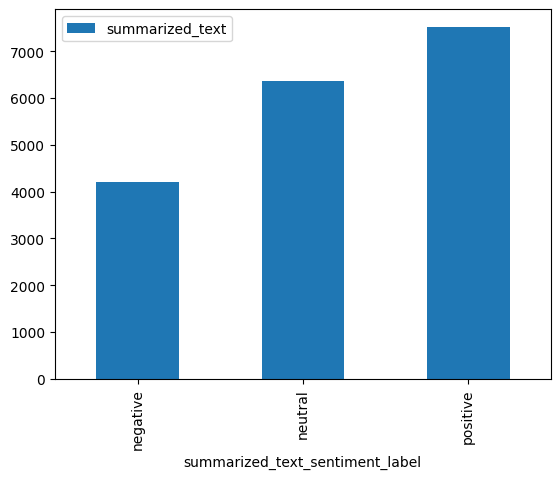

In [7]:
df_copy.groupby('summarized_text_sentiment_label').count().plot(kind='bar')

Данные не сбалансированы, поэтому метрику будем использовать `F1-score`

**Кодируем целевой признак**

In [8]:
df_copy['summarized_text_sentiment_label'] = df_copy.summarized_text_sentiment_label.map({'negative': 0, 'neutral': 1, 'positive': 2})

In [9]:
df_copy['summarized_text_sentiment_label'].unique()

array([0, 1, 2])

**Переводим текст в нижний регистр**

In [10]:
df_copy['summarized_text'] = df_copy.summarized_text.map(lambda x: x.lower())

**Удаление знаков препинания и цифр**

In [11]:
import re

def clean_text(text):
    text = re.sub(r'[^\sа-яА-ЯёЁ0-9@\[\]]', ' ', text)  # Удаляет пунктуацию
    text = re.sub(r'\w*\d+\w*', '', text)  # Удаляет цифры
    text = re.sub(r'\s{2,}', ' ', text)  # Удаляет ненужные пробелы
    return text

In [12]:
df_copy['summarized_text'] = df_copy['summarized_text'].apply(clean_text)

In [13]:
df_copy2=df_copy.copy()

**Токенизация**

In [14]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
df_copy['summarized_text'] = df_copy['summarized_text'].apply(nltk.word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


**Стемминг**

In [15]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("russian")
df_copy['summarized_text'] = df_copy['summarized_text'].apply(lambda x: [stemmer.stem(y) for y in x])

**Посмотрим как выглядит текст теперь**

In [16]:
df_copy.head(5)

,summarized_text,summarized_text_sentiment_label
0,"[спрос, на, морск, перевозк, из, аз, в, сша, у...",0
1,"[банк, росс, возобнов, операц, с, иностра, вал...",1
2,"[ожида, замедлен, инфляц, в, сша, замедл, до, ...",0
3,"[вслед, за, возвращен, бюджетн, прав, в, росс,...",2
4,"[сбер, зафиксирова, годов, обва, приб, на, в, ...",0


In [17]:
df_copy1=df_copy.copy()

### Векторизация(частотная)

### Переводим текст в числа с помощью метода "Мешок слов" (Bag of Words, BoW)

**Определение:**  
**Мешок слов** — это метод векторного представления текста, где текст рассматривается как неупорядоченный набор (мешок) слов без учета грамматики, порядка слов, но с учетом частоты их встречаемости. Каждый документ (текст) преобразуется в вектор чисел, где каждое число соответствует частоте определенного слова в словаре.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
# преобразуем список слов в строки, разделенные пробелами
df_copy['summarized_text'] = df_copy['summarized_text'].apply(lambda x: ' '.join(x))
count_vect = CountVectorizer()
counts = count_vect.fit_transform(df_copy['summarized_text'])

In [19]:
counts.shape

(18107, 12411)

### Обучение моделей.

**Разбиваем выборку на обучающую и тестовую**

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(counts, df_copy['summarized_text_sentiment_label'], test_size=0.25)

### Пробуем обучение на модели "Дерево решений" (Decision Tree)

**Определение:**  
**Дерево решений** — это алгоритм машинного обучения для задач классификации и регрессии, который строит иерархическую структуру правил вида "если-то", разбивая данные на подмножества на основе значений признаков. Каждый внутренний узел дерева соответствует условию (признаку), каждая ветвь — возможному значению признака, а каждый лист — предсказанному классу (например, тональности `negative/neutral/positive`).

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

param_grid = {
    'max_depth': [100, 150, 200]  # Возможные значения для максимальной глубины
}

# Построение дерева решений
dectree = DecisionTreeClassifier(random_state=21)
# Создание GridSearchCV
grid_search = GridSearchCV(estimator=dectree, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
# Обучение на обучающей выборке
best_dectree = grid_search.best_estimator_
y_train_pred = best_dectree.predict(X_train)
y_test_pred = best_dectree.predict(X_test)

Best Parameters: {'max_depth': 150}


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.53      0.50      0.51      1041
           1       0.62      0.66      0.64      1600
           2       0.67      0.65      0.66      1886

    accuracy                           0.62      4527
   macro avg       0.61      0.61      0.61      4527
weighted avg       0.62      0.62      0.62      4527



**Вывод:** Метрика получилась неочень большой, значит пробуем другие модели.

### Пробуем модель "Случайный лес" (Random Forest)

**Определение:**
**Случайный лес** — это ансамблевый алгоритм машинного обучения, который строит множество деревьев решений (обычно десятки или сотни) и объединяет их предсказания для получения более точного и стабильного результата. Каждое дерево в лесе обучается на случайном подмножестве данных (бутстрэп-выборка) и рассматривает случайное подмножество признаков при каждом разбиении. Итоговое предсказание определяется путем голосования (для классификации) или усреднения (для регрессии) всех деревьев.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=21)
# Определение параметров для поиска с увеличенным количеством значений
param_grid = {
    'n_estimators': [10, 50, 100, 150, 200],  # Значений для количества деревьев
    'max_depth': [ 5, 10, 15],  # Значений для максимальной глубины
    'min_samples_split': [2, 5, 10],  # Минимальное число samples для разделения узла
    'min_samples_leaf': [1, 2, 4]     # Минимальное число samples в листе
}

# Создание GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Поиск наилучших параметров
grid_search.fit(X_train, y_train)

# Вывод наилучших параметров и оценки
print("Best Parameters:", grid_search.best_params_)

# Использование наилучшей модели для предсказаний
best_rfc = grid_search.best_estimator_
rfc_train_pred = best_rfc.predict(X_train)
rfc_test_pred = best_rfc.predict(X_test)

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [24]:
print(classification_report(y_test, rfc_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.09      0.17      1041
           1       0.65      0.71      0.68      1600
           2       0.61      0.85      0.71      1886

    accuracy                           0.63      4527
   macro avg       0.71      0.55      0.52      4527
weighted avg       0.69      0.63      0.57      4527



**Вывод:** Метрика небольшая, значит пробуем другой метод.

### Пробуем наивный байесовский классификатор (Naive Bayes)

**Определение:**
**Наивный байесовский классификатор** — это вероятностный алгоритм машинного обучения, основанный на теореме Байеса с предположением о независимости признаков (отсюда "наивный"). Для текстовых данных он вычисляет вероятность принадлежности текста к определенному классу (например, тональности) на основе частоты встречаемости слов.

In [28]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train, y_train)

In [29]:
predictions = model.predict(X_test)

In [30]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.58      0.59      0.58      1041
           1       0.73      0.71      0.72      1600
           2       0.74      0.75      0.74      1886

    accuracy                           0.70      4527
   macro avg       0.68      0.68      0.68      4527
weighted avg       0.70      0.70      0.70      4527



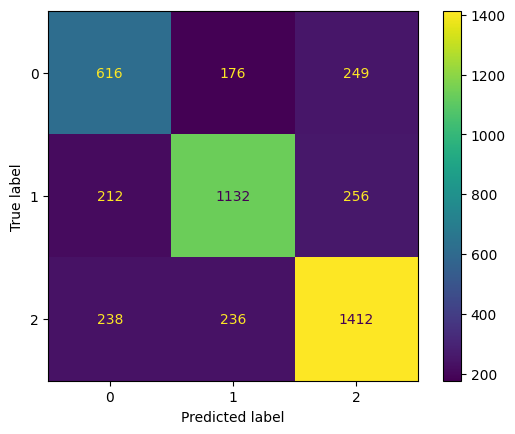

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
cm_display.plot()

**Вывод:** Метрики стали лучше, но попробуем еще модели.

### Пробуем SGDClassifier

**Определение:**
**SGDClassifier** — это линейный классификатор, который использует метод стохастического градиентного спуска (Stochastic Gradient Descent) для обучения модели. Этот метод оптимизации обновляет веса модели итеративно, используя одно или несколько обучающих примеров за раз, что делает его эффективным для работы с большими наборами данных. SGDClassifier поддерживает различные функции потерь, такие как шарнирная потеря для SVM (Support Vector Machines), логистическая потеря для логистической регрессии и другие, что делает его универсальным инструментом для задач классификации.

In [32]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
clf = SGDClassifier()
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)

In [33]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.73      0.70      0.72      1041
           1       0.75      0.76      0.75      1600
           2       0.81      0.82      0.81      1886

    accuracy                           0.77      4527
   macro avg       0.76      0.76      0.76      4527
weighted avg       0.77      0.77      0.77      4527



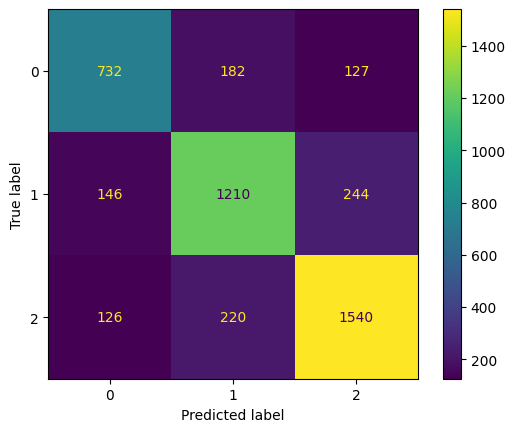

In [34]:
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cm_display.plot()

# Результаты анализа моделей классификации

## Лучшие модели:
- **Наивный байесовский классификатор**
- **Линейный классификатор**

## Вывод:
Данные модели показали наилучшие метрики, что делает их наиболее подходящими для решения данной задачи.

### Векторизация(семантическая)

Переходим к семантической векторизации методом `Word2Vec`. После предобработки я скопировала датасет, а только после этого применяла частоную векторизацию, поэтому здесь работаю с предобработаным датасетом, к кторому осталось только применить другую векторизацию.

In [35]:
from gensim.models import Word2Vec
sentences = df_copy1['summarized_text'].tolist()
w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)
def vectorize(sentence):
    words_vecs = [w2v_model.wv[word] for word in sentence if word in w2v_model.wv]

    if len(words_vecs) == 0:
        return np.zeros(100)

    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [32]:
!pip uninstall -y gensim scipy numpy
!pip install scipy==1.10.1 numpy==1.23.5 gensim==4.3.2

Found existing installation: scipy 1.15.2
Uninstalling scipy-1.15.2:
  Successfully uninstalled scipy-1.15.2
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 10.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 re

In [1]:
from scipy.linalg import triu  # Проверка импорта SciPy
from gensim.models import Word2Vec  # Проверка импорта Gensim
print("Все импортируется успешно!")

Все импортируется успешно!


**Применяем семантическую векторизацию**

In [36]:
X = np.array([vectorize(sentence) for sentence in df_copy1['summarized_text']])

**Разбиваем выборку на тренировочную и обучающую**

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, df_copy1['summarized_text_sentiment_label'], test_size=0.25)

**Строим модель линейного классификатора, так как она оказалась лучшей**

In [38]:
clf = SGDClassifier()
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)

In [39]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.51      0.44      0.47      1072
           1       0.65      0.70      0.67      1546
           2       0.69      0.69      0.69      1909

    accuracy                           0.64      4527
   macro avg       0.61      0.61      0.61      4527
weighted avg       0.63      0.64      0.63      4527



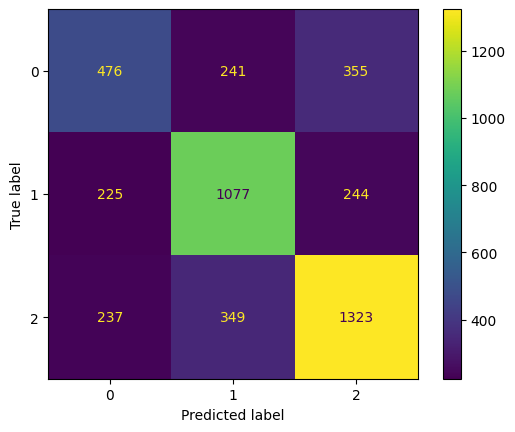

In [40]:
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cm_display.plot()

**Вывод:** Получилась маленькая точность, что означает, что для данного набора данных не подходит семантическая векторизация.

### Встроенная библиотека catboost

Также в Python есть встроенные библиотеки, которые не требуют предобработки датасета. Восполльзуемся одной из них catboost.

### Пробуем CatBoost

**Определение:**
**CatBoost** — это алгоритм градиентного бустинга, разработанный компанией Yandex. Он особенно эффективен для работы с категориальными признаками, что делает его популярным выбором для задач машинного обучения, где данные содержат много категориальных переменных. CatBoost автоматически обрабатывает категориальные признаки, что упрощает процесс предобработки данных.

**Основные особенности:**
- **Обработка категориальных признаков:** CatBoost автоматически кодирует категориальные признаки, что позволяет избежать ручной предобработки данных.
- **Устойчивость к переобучению:** Алгоритм включает в себя различные методы для борьбы с переобучением, такие как регуляризация и случайное подпространство признаков.
- **Высокая производительность:** CatBoost показывает высокую производительность на больших наборах данных и поддерживает распределенное обучение.
- **Поддержка различных задач:** CatBoost может использоваться для задач классификации, регрессии и ранжирования.

In [41]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00


**Разбиваем выборку**

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df_copy2['summarized_text'], df_copy2['summarized_text_sentiment_label'], test_size=0.25)

**Представляем данные в виде нужнoм для catboost**

In [43]:
train_data = pd.DataFrame({
    'text': X_train,
    'label': y_train
})

test_data = pd.DataFrame({
    'text': X_test,
    'label': y_test
})

**Строим модель**

In [44]:
from catboost import CatBoostClassifier
model_cat = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=3,
    loss_function='MultiClass',
    verbose=100
)

model_cat.fit(
    train_data,
    train_data['label'],
    text_features=['text'],
    eval_set=(test_data, test_data['label'])
)

0:	learn: 0.9094668	test: 0.9096187	best: 0.9096187 (0)	total: 1.72s	remaining: 2m 50s
99:	learn: 0.0002167	test: 0.0002157	best: 0.0002157 (99)	total: 46.7s	remaining: 0us

bestTest = 0.0002157050957
bestIteration = 99



**Делаем предсказания**

In [45]:
predictions = model_cat.predict(test_data)

In [46]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1032
           1       1.00      1.00      1.00      1569
           2       1.00      1.00      1.00      1926

    accuracy                           1.00      4527
   macro avg       1.00      1.00      1.00      4527
weighted avg       1.00      1.00      1.00      4527



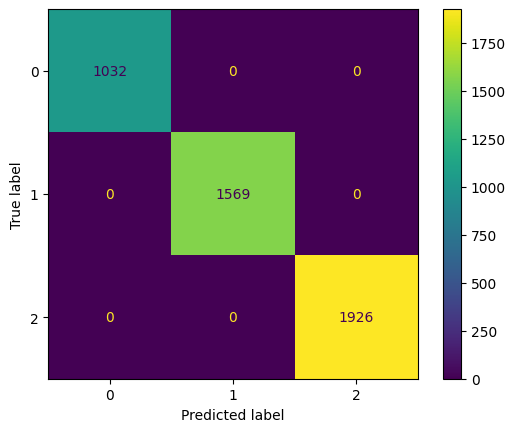

In [47]:
cm = confusion_matrix(y_test, predictions, labels=model_cat.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_cat.classes_)
cm_display.plot()

**Вывод:** Точность получилась максимально точной, что подтверждает эффективность модели catboost.

# **Общие выводы**

В ходе выполнения работы была проведена предварительная обработка текста, включающая следующие этапы:
- Приведение текста к нижнему регистру.
- Удаление пунктуации и цифр.
- Токенизация текста.
- Стемминг.

Далее была осуществлена векторизация текста с использованием двух методов:
- Частотная векторизация (мешок слов).
- Семантическая векторизация (Word2Vec).

Для частотной векторизации были построены и оценены следующие модели:
- Дерево решений с точностью 0.64.
- Случайный лес с точностью 0.63.
- Наивный байесовский классификатор с точностью 0.7.
- Линейный классификатор с точностью 0.77.

Для семантической векторизации была построена модель линейного классификатора с точностью 0.62.

Также была построена модель CatBoost на сырых данных, которая показала точность 1.0.

# Заключение

В результате проведенного анализа и построения моделей можно сделать следующие выводы:
- Предварительная обработка текста является важным этапом для улучшения качества данных.
- Частотная векторизация показала лучшие результаты по сравнению с семантической векторизацией для используемых моделей.
- Модель CatBoost на сырых данных показала наивысшую точность, что может свидетельствовать о ее высокой эффективности для данной задачи.